## **A**utomated **L**earning for **I**nsightful **C**omparison and **E**valuation - (ALICE)

This is a demo notebook where I demonstrate the main functionalities of the proposed python framework.

For demonstrational purposes, I will be using a simple and small dataset called California Housing, which includes 8 predictors and 1 target (`MedHouseVal`) - which is a house value. This amount of predictors is small for us but a small dataset helps to run the python framework in a short amount of time, so it is very suitable for demonstration purposes.

Because all of the variables in the dataset are continuous, I simulate a binary categorical column from MedHouseVal which just measures if house value is above average. 

I also generate a fake categorical variable just to demonstrate the framework's functionality to treat $n$ amount of columns obtained from dummy encoding of a categorical variable as one variable in feature selection process.

Further details are given in comments and markdown notes throughout the notebook.

In [90]:
# Import numpy for mathematical operations
import numpy as np
# Import pandas for handling data tables
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# Import stats from scipy - the key statistical package (an extension of Numpy) for python
from scipy import stats

# import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

# This just saves the directory
import os
cur_dir = os.getcwd()
import pickle

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import keras_tuner


### Import My Framework

In [2]:
# Can just import entire module
import alice

**Individual Functions:**

In [3]:
# Or import individual functions

# Import regression metrics
from alice.metrics.regress import mse, rmse, mae
# Import classification metrics
from alice.metrics.classify import accuracy, precision, recall, f1

# Import regression agreeability metric
from alice.agreeability.regress import pearson
# Import classification agreeability metric
from alice.agreeability.classify import cohen_kappa

# Import regression tests
from alice.testing.regress import t_test
# Import classification tests
from alice.testing.classify import mcnemar_binomial, mcnemar_chisquare

**Algorithm That Combines Backwards Feature Elimination with Inter-Rater Reliability:**

In [4]:
# Import our demo search algorithm 
from alice.search_and_compare.sequential import BackEliminator

In [5]:
# We can look at my documentation for the BackEliminator
BackEliminator?

Init signature:
BackEliminator(
    X=None,
    y=None,
    validation_data=None,
    task_type=None,
    criterion=None,
    agreeability=None,
    dummy_list=None,
    features_to_fix=None,
)
Docstring:     
The class is built for conducting backwards feature elimination in combination with model agreeability. A more detailed documentation will follow.

Args:
    X (pd.DataFrame): A pandas dataframe containing predictors.
    y (pd.DataFrame): A pandas dataframe containing target.
    validation_data (tuple): A tuple of validation data (X_val, y_val).
    task_type (str): String for task type. Available options - 'classification' or 'regression'.
    criterion (str): String for intra-model evaluation criterion. Available options: 'mse', 'rmse', 'mae', 'accuracy', 'precision', 'recall', 'f1'.
    agreeability (str): String for inter-model comparison. Available options: 'pearson', 'cohen_kappa'
    dummy_list (list): List of lists containing column names (str) of dummy features generat

### Import the Data

In [77]:
## Set up paths (to either save or import the datasets)
raw_train_path = 'clean_data/class_telco/raw_train.pkl'
upsampled_train_path = 'clean_data/class_telco/upsampled_train.pkl'
test_path = 'clean_data/class_telco/test.pkl'


### Load Upsampled Datasets

In [78]:
# Load upsampled train set
with open(upsampled_train_path, 'rb') as f:
    train = pickle.load(f)

# Load test set (unchanged)
with open(test_path, 'rb') as f:
    test = pickle.load(f)

In [83]:
# obtain a list of columns we need to fix
dummies_togroup = [feature for feature in train.columns if train[feature].dtype == 'uint8']

In [84]:
for item in dummies_togroup:
    print(item)

MultipleLines_No_phone_service
MultipleLines_Yes
InternetService_Fiber_optic
InternetService_No
OnlineSecurity_No_internet_service
OnlineSecurity_Yes
OnlineBackup_No_internet_service
OnlineBackup_Yes
DeviceProtection_No_internet_service
DeviceProtection_Yes
TechSupport_No_internet_service
TechSupport_Yes
StreamingTV_No_internet_service
StreamingTV_Yes
StreamingMovies_No_internet_service
StreamingMovies_Yes
Contract_One_year
Contract_Two_year
PaymentMethod_Credit_card_(automatic)
PaymentMethod_Electronic_check
PaymentMethod_Mailed_check


In [85]:
# Group the dummies in a list to input to the framework
dummy_list = [
    ['MultipleLines_No_phone_service', 'MultipleLines_Yes'],
    ['InternetService_Fiber_optic', 'InternetService_No'],
    ['OnlineSecurity_No_internet_service', 'OnlineSecurity_Yes'],
    ['OnlineBackup_No_internet_service', 'OnlineBackup_Yes'],
    ['DeviceProtection_No_internet_service', 'DeviceProtection_Yes'],
    ['TechSupport_No_internet_service', 'TechSupport_Yes'],
    ['StreamingTV_No_internet_service', 'StreamingTV_Yes'],
    ['StreamingMovies_No_internet_service', 'StreamingMovies_Yes'],
    ['Contract_One_year', 'Contract_Two_year'],
    ['PaymentMethod_Credit_card_(automatic)', 'PaymentMethod_Electronic_check', 'PaymentMethod_Mailed_check']
]
dummy_list

[['MultipleLines_No_phone_service', 'MultipleLines_Yes'],
 ['InternetService_Fiber_optic', 'InternetService_No'],
 ['OnlineSecurity_No_internet_service', 'OnlineSecurity_Yes'],
 ['OnlineBackup_No_internet_service', 'OnlineBackup_Yes'],
 ['DeviceProtection_No_internet_service', 'DeviceProtection_Yes'],
 ['TechSupport_No_internet_service', 'TechSupport_Yes'],
 ['StreamingTV_No_internet_service', 'StreamingTV_Yes'],
 ['StreamingMovies_No_internet_service', 'StreamingMovies_Yes'],
 ['Contract_One_year', 'Contract_Two_year'],
 ['PaymentMethod_Credit_card_(automatic)',
  'PaymentMethod_Electronic_check',
  'PaymentMethod_Mailed_check']]

In [86]:
# Get X_train and X_test

# Drop target from predictors in the train set
X_train = train.drop('ChurnValue', axis=1)

# Drop target from predictors in the validation set
X_val = test.drop('ChurnValue', axis=1)

# Get y_train and y_test
y_train = train['ChurnValue']
y_val = test['ChurnValue']

if len(X_train) == len(y_train) and len(X_val) == len(y_val): 
    print('Everything went well.')

Everything went well.


In [91]:
# Get the names of the columns to be scaled
float_cols = X_train.select_dtypes(include=['float64']).columns

# Create the ColumnTransformer
standardizer = make_column_transformer(
    (StandardScaler(), float_cols),
    remainder='passthrough'
)

# Apply the transformations
X_train_scaled = standardizer.fit_transform(X_train)
X_val_scaled = standardizer.transform(X_val)

# Get the order of columns after transformation
transformed_columns_order = list(float_cols) + [col for col in X_train.columns if col not in float_cols]

# Reconstruct the DataFrame with the correct column order
X_train_scaled = pd.DataFrame(X_train_scaled, columns=transformed_columns_order)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=transformed_columns_order)


### (OPTIONAL) KERAS TUNING for Neural Networks

In this small subsection I do a gridsearch over some hyperparameters for a Neural Network classifier (this is not related to the framework), so skip this section

In [14]:
## Turn into tensors for tensorflow
X_train_tensor = tf.cast(X_train_scaled.values, dtype=tf.float32) ###
y_train_tensor = tf.cast(y_train.values, dtype=tf.float32) ###

2024-01-22 20:53:27.840084: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43604 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:17:00.0, compute capability: 8.6
2024-01-22 20:53:27.848187: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43604 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:65:00.0, compute capability: 8.6


In [31]:
tf.keras.layers.Dense?

Init signature:
tf.keras.layers.Dense(
    units,
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs,
)
Docstring:     
Just your regular densely-connected NN layer.

`Dense` implements the operation:
`output = activation(dot(input, kernel) + bias)`
where `activation` is the element-wise activation function
passed as the `activation` argument, `kernel` is a weights matrix
created by the layer, and `bias` is a bias vector created by the layer
(only applicable if `use_bias` is `True`). These are all attributes of
`Dense`.

Note: If the input to the layer has a rank greater than 2, then `Dense`
computes the dot product between the `inputs` and the `kernel` along the
last axis of the `inputs` and axis 0 of the `kernel` (using `tf.tensordot`).
For example, if input has dimensions 

In [34]:
model = tf.keras.Sequential()
model.add(
    tf.keras.layers.Dense(16, 'relu'),
)
model.add(tf.keras.layers.Dense(1, 'sigmoid'))
model.compile()

In [55]:
# The function defines a "hypermodel" that can be used for hyperparameter optimization algorithm

def build_model(hp):
    
    # Create keras neural network instance
    model = tf.keras.Sequential()
    
    # Add a feed-forward layer (Dense) with Rectified Linear Unit (RELU) activation function - f(x) = max(0, x)
    # Grid search will try out 64, 128, 256 and 512 neurons in this layer
    model.add(
        tf.keras.layers.Dense(
            units=hp.Choice(name='units_layer_1', values=[64, 128, 256, 512]),
            activation='relu'
        )
    )

    # Add a feed-forward layer (Dense) with Rectified Linear Unit (RELU) activation function - f(x) = max(0, x)
    # Grid search will try out 8, 16, 21 and 64 neurons in this layer
    model.add(
        tf.keras.layers.Dense(
            units=hp.Choice(name='units_layer_2', values=[8, 16, 32, 64]),
            activation='relu'
        )
    )

    # Whether to include a dropout layer that deactivates outputs of 20% of the neurons
    # Grid search will try the neuron combinations above with dropout and then without
    if hp.Boolean('dropout'):
        model.add(tf.keras.layers.Dropout(rate=0.2))
    
    # A layer with a single neuron --- the output layer. Activation used 'sigmoid' --- essentially a logistic function used for classification head
    model.add(
        tf.keras.layers.Dense(
            units=1,
            activation='sigmoid'
        )
    )
    
    # Define learning rate --- 0.0001, 0.01, 0.001 will be tried out in the gridsearch
    learning_rate = hp.Choice(name='lr', values=[1e-4, 1e-2, 1e-3])

    # Compile model with
    # Optimizer --- Adaptive Moment Estimation with learning rate choice specified above
    # Loss function --- Binary Cross-Entropy
    # Metrics --- this is a metric (in this case accuracy) that we'll just keep track of during training
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )
    
    # Retunr
    return model

build_model(keras_tuner.HyperParameters())

In [56]:
# Setting up tuner
# initialize a tuner with grid search

tuner = keras_tuner.GridSearch(
    hypermodel=build_model, # specify build_model defined above as a hypermodel
    objective = keras_tuner.Objective(name='accuracy', direction='max'), #maximize out-of-sample predictive 'accuracy' --- wanted to use f1 instead but ther was a problem
    executions_per_trial=2, # In each search trial, model will be fitted twice
    overwrite=True, # Logs results
    directory = 'logs', # Logs results
    project_name = 'class_telco'# Logs results
)

# Setting up early stopping
# Monitors validation loss, will stop after 5 training epochs if there is no improvement
# Restores weights from the best iteration
STOP_EARLY = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Print search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 4
units_layer_1 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256, 512], 'ordered': True}
units_layer_2 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64], 'ordered': True}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.01, 0.001], 'ordered': True}


In [57]:
# Begin the search
tuner.search(X_train_tensor, y_train_tensor, epochs=100, validation_split=0.2, callbacks=[STOP_EARLY])

Trial 96 Complete [00h 00m 34s]
accuracy: 0.62507563829422

Best accuracy So Far: 0.7714760899543762
Total elapsed time: 01h 01m 48s


In [58]:
# PRINT 10 best RESULTS
tuner.results_summary()

Results summary
Results in logs/class_telco
Showing 10 best trials
Objective(name="accuracy", direction="max")

Trial 0043 summary
Hyperparameters:
units_layer_1: 128
units_layer_2: 64
dropout: False
lr: 0.01
Score: 0.7714760899543762

Trial 0072 summary
Hyperparameters:
units_layer_1: 512
units_layer_2: 8
dropout: False
lr: 0.0001
Score: 0.7704174518585205

Trial 0019 summary
Hyperparameters:
units_layer_1: 64
units_layer_2: 64
dropout: False
lr: 0.01
Score: 0.7633847594261169

Trial 0030 summary
Hyperparameters:
units_layer_1: 128
units_layer_2: 16
dropout: False
lr: 0.0001
Score: 0.7611161470413208

Trial 0061 summary
Hyperparameters:
units_layer_1: 256
units_layer_2: 32
dropout: False
lr: 0.01
Score: 0.760511189699173

Trial 0024 summary
Hyperparameters:
units_layer_1: 128
units_layer_2: 8
dropout: False
lr: 0.0001
Score: 0.7583938241004944

Trial 0000 summary
Hyperparameters:
units_layer_1: 64
units_layer_2: 8
dropout: False
lr: 0.0001
Score: 0.757637619972229

Trial 0037 summary


### Running the algorithms

To use with my algorithm, I can based on this results use a Neural Network of the following specifications:

- layer 1 units 128
- layer 2 units 64
- no dropout layer
- learning rate of 0.01

In [93]:
# Import logistic regression
from sklearn.linear_model import LogisticRegression

# Import Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# Import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

In [94]:
# Initialize logistic regressor
logit = LogisticRegression(solver='liblinear')

# Initialize random forest ensemble of 50 classifiers
rfc = RandomForestClassifier(n_estimators=100)

In [96]:
# These are helper utilities I coded for my framework to be able 
# to incorporate neural networks and still maintain the user-friendly interface of Keras
from alice.utils.model_training import KerasSequential # This is for defining a neural network model to put into the elimination-agreeability algorithm
from alice.utils.model_training import KerasParams # This is for defining training parameters to put into the elimination-agreeability algorithm
from alice.utils.model_training import ModelTrainer # This is a wrapper function that is used for training --- I do not use it here in the Notebook because the algorithm calls it inside

Initializing a small neural network to save computing time

In [97]:
mlp = KerasSequential() # Initialize multi-layer perceptron (classifier neural net) as my KerasSequential class
mlp.add(tf.keras.layers.Dense, units=128, activation='linear') # for now I just use 16 units in first layer
mlp.add(tf.keras.layers.Dense, units=64, activation='linear') # 8 units in second layer
mlp.add(tf.keras.layers.Dense, units=1, activation='sigmoid') # Sigmoid for classification

mlp.compile(
    optimizer='adam', # adaptive moment estimation as optimizer (default learning rate of 0.001)
    loss=tf.keras.losses.BinaryCrossentropy(), # Binary Cross-entropy as loss
    metrics=['accuracy'] # Track accuracy
    )

In [98]:
# Set up Keras parameters to include with our model

# early stopping after 10 epochs with no improvement
EARLY_STOPPING = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]


# KerasParams is a class I coded that can be predefined and fed to my algorithm as an optional argument when including a neural network in it
keras_params = KerasParams(
    batch_size=32, # batch size for mini-batch training
    epochs=100, # fit a model for 100 epochs (is too much but early stopping ensures models stop earlier)
    validation_split=0.2, # further 0.8-0.2 split in the training set --- early stopping will happen based on evaluations on this
    callbacks=EARLY_STOPPING, # include early stopping as a training callbakc
    verbose=0 # irrelevant
)

### BackEliminator with RandomForestClassifier and MultiLayerPerceptron

In [99]:
# Initialize my algorithm
seeker = BackEliminator(
    X=X_train_scaled, # predictor
    y=y_train, # target
    validation_data=(X_val_scaled, y_val), # validation datasets for evaluation
    task_type='classification', # select classification task
    criterion='f1', # select f1 score for feature elimination 
    agreeability='cohen_kappa', # select cohen's kappa as inter rater agreeability
    dummy_list=dummy_list # List of dummy variables to group together when evaluating features
)

In [100]:
# Run the comparison algorithm 
results = seeker.compare_all_models(
    m1=rfc, # Model 1: Logistic Regression
    m2=mlp, # Model 2: Neural Network Classifier // Replace with 'rcf' - random forest classifier for testing the framework on a CPU to save time
    keras_params=keras_params # Provide parameters for training the neural network
)

Initial run: fitted both models with full feature set.
------------------------------------------------------------------------------------------------------------------------------------------------------
Model 1 included: ['Latitude', 'Longitude', 'TenureMonths', 'MonthlyCharges', 'TotalCharges', 'CLTV', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', ['MultipleLines_No_phone_service', 'MultipleLines_Yes'], ['InternetService_Fiber_optic', 'InternetService_No'], ['OnlineSecurity_No_internet_service', 'OnlineSecurity_Yes'], ['OnlineBackup_No_internet_service', 'OnlineBackup_Yes'], ['DeviceProtection_No_internet_service', 'DeviceProtection_Yes'], ['TechSupport_No_internet_service', 'TechSupport_Yes'], ['StreamingTV_No_internet_service', 'StreamingTV_Yes'], ['StreamingMovies_No_internet_service', 'StreamingMovies_Yes'], ['Contract_One_year', 'Contract_Two_year'], ['PaymentMethod_Credit_card_(automatic)', 'PaymentMethod_Electronic_check', 'PaymentMe

In [101]:
results

[{'Best: M1 Included Features': ['Latitude',
   'Longitude',
   'TenureMonths',
   'MonthlyCharges',
   'TotalCharges',
   'CLTV',
   'Gender',
   'SeniorCitizen',
   'Partner',
   'Dependents',
   'PhoneService',
   'PaperlessBilling',
   'MultipleLines_No_phone_service',
   'MultipleLines_Yes',
   'InternetService_Fiber_optic',
   'InternetService_No',
   'OnlineSecurity_No_internet_service',
   'OnlineSecurity_Yes',
   'OnlineBackup_No_internet_service',
   'OnlineBackup_Yes',
   'DeviceProtection_No_internet_service',
   'DeviceProtection_Yes',
   'TechSupport_No_internet_service',
   'TechSupport_Yes',
   'StreamingTV_No_internet_service',
   'StreamingTV_Yes',
   'StreamingMovies_No_internet_service',
   'StreamingMovies_Yes',
   'Contract_One_year',
   'Contract_Two_year',
   'PaymentMethod_Credit_card_(automatic)',
   'PaymentMethod_Electronic_check',
   'PaymentMethod_Mailed_check'],
  'Best: M1 f1': 0.607095926412615,
  'Best: M2 Included Features': ['Latitude',
   'Longitude

In [102]:
results_df = seeker.dataframe_from_results()

In [109]:
RESULTS_PATH = 'test_results/rfc_mlp/rfc_mlp.pkl'

with open(RESULTS_PATH, 'wb') as f:
    pickle.dump(results_df, f)

In [103]:
seeker.plot_from_results()

In [104]:
seeker.compare_n_best(n=21, test='mcnemar_chisquare')

Model 1: Results for No. 1 and No. 2 best predictions: P-value: 0.00000000. Test statistic: 179.21403509.
Model 2: Results for No. 1 and No. 2 best predictions: P-value: 0.00000000. Test statistic: 212.38795987.
Model 1: Results for No. 2 and No. 3 best predictions: P-value: 0.00000000. Test statistic: 129.33673469.
Model 2: Results for No. 2 and No. 3 best predictions: P-value: 0.00000000. Test statistic: 202.10526316.
Model 1: Results for No. 3 and No. 4 best predictions: P-value: 0.00000000. Test statistic: 173.61937716.
Model 2: Results for No. 3 and No. 4 best predictions: P-value: 0.00000000. Test statistic: 163.89597315.
Model 1: Results for No. 4 and No. 5 best predictions: P-value: 0.00000000. Test statistic: 184.99644128.
Model 2: Results for No. 4 and No. 5 best predictions: P-value: 0.00000000. Test statistic: 209.38019169.
Model 1: Results for No. 5 and No. 6 best predictions: P-value: 0.00000000. Test statistic: 139.60071942.
Model 2: Results for No. 5 and No. 6 best pred

### BackEliminator with Logit and MultiLayerPerceptron

In [110]:
# Initialize my algorithm
seeker_2 = BackEliminator(
    X=X_train_scaled, # predictor
    y=y_train, # target
    validation_data=(X_val_scaled, y_val), # validation datasets for evaluation
    task_type='classification', # select classification task
    criterion='f1', # select f1 score for feature elimination 
    agreeability='cohen_kappa', # select cohen's kappa as inter rater agreeability
    dummy_list=dummy_list # List of dummy variables to group together when evaluating features
)

In [111]:
# Run the comparison algorithm 
results_2 = seeker_2.compare_all_models(
    m1=logit, # Model 1: Logistic Regression
    m2=mlp, # Model 2: Neural Network Classifier // Replace with 'rcf' - random forest classifier for testing the framework on a CPU to save time
    keras_params=keras_params # Provide parameters for training the neural network
)

Initial run: fitted both models with full feature set.
------------------------------------------------------------------------------------------------------------------------------------------------------
Model 1 included: ['Latitude', 'Longitude', 'TenureMonths', 'MonthlyCharges', 'TotalCharges', 'CLTV', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', ['MultipleLines_No_phone_service', 'MultipleLines_Yes'], ['InternetService_Fiber_optic', 'InternetService_No'], ['OnlineSecurity_No_internet_service', 'OnlineSecurity_Yes'], ['OnlineBackup_No_internet_service', 'OnlineBackup_Yes'], ['DeviceProtection_No_internet_service', 'DeviceProtection_Yes'], ['TechSupport_No_internet_service', 'TechSupport_Yes'], ['StreamingTV_No_internet_service', 'StreamingTV_Yes'], ['StreamingMovies_No_internet_service', 'StreamingMovies_Yes'], ['Contract_One_year', 'Contract_Two_year'], ['PaymentMethod_Credit_card_(automatic)', 'PaymentMethod_Electronic_check', 'PaymentMe

In [112]:
results_2

[{'Best: M1 Included Features': ['Latitude',
   'Longitude',
   'TenureMonths',
   'MonthlyCharges',
   'TotalCharges',
   'CLTV',
   'Gender',
   'SeniorCitizen',
   'Partner',
   'Dependents',
   'PhoneService',
   'PaperlessBilling',
   'MultipleLines_No_phone_service',
   'MultipleLines_Yes',
   'InternetService_Fiber_optic',
   'InternetService_No',
   'OnlineSecurity_No_internet_service',
   'OnlineSecurity_Yes',
   'OnlineBackup_No_internet_service',
   'OnlineBackup_Yes',
   'DeviceProtection_No_internet_service',
   'DeviceProtection_Yes',
   'TechSupport_No_internet_service',
   'TechSupport_Yes',
   'StreamingTV_No_internet_service',
   'StreamingTV_Yes',
   'StreamingMovies_No_internet_service',
   'StreamingMovies_Yes',
   'Contract_One_year',
   'Contract_Two_year',
   'PaymentMethod_Credit_card_(automatic)',
   'PaymentMethod_Electronic_check',
   'PaymentMethod_Mailed_check'],
  'Best: M1 f1': 0.634207240948814,
  'Best: M2 Included Features': ['Latitude',
   'Longitude

In [113]:
results_df_2 = seeker_2.dataframe_from_results()

In [114]:
seeker_2.plot_from_results()

In [115]:
seeker_2.compare_n_best(n=21, test='mcnemar_chisquare')

Model 1: Results for No. 1 and No. 2 best predictions: P-value: 0.00000000. Test statistic: 283.08532423.
Model 2: Results for No. 1 and No. 2 best predictions: P-value: 0.00000000. Test statistic: 136.48986486.
Model 1: Results for No. 2 and No. 3 best predictions: P-value: 0.00000000. Test statistic: 277.27457627.
Model 2: Results for No. 2 and No. 3 best predictions: P-value: 0.00000000. Test statistic: 201.04983389.
Model 1: Results for No. 3 and No. 4 best predictions: P-value: 0.00000000. Test statistic: 203.95065789.
Model 2: Results for No. 3 and No. 4 best predictions: P-value: 0.00000000. Test statistic: 217.22558923.
Model 1: Results for No. 4 and No. 5 best predictions: P-value: 0.00000000. Test statistic: 204.72818792.
Model 2: Results for No. 4 and No. 5 best predictions: P-value: 0.00000000. Test statistic: 239.60596026.
Model 1: Results for No. 5 and No. 6 best predictions: P-value: 0.00000000. Test statistic: 274.56333333.
Model 2: Results for No. 5 and No. 6 best pred

In [116]:
RESULTS_PATH = 'test_results/logit_mlp/logit_mlp.pkl'

with open(RESULTS_PATH, 'wb') as f:
    pickle.dump(results_df_2, f)

### BackEliminator with Logit and RandomForestClassifier

In [120]:
# Initialize my algorithm
seeker_3 = BackEliminator(
    X=X_train_scaled, # predictor
    y=y_train, # target
    validation_data=(X_val_scaled, y_val), # validation datasets for evaluation
    task_type='classification', # select classification task
    criterion='f1', # select f1 score for feature elimination 
    agreeability='cohen_kappa', # select cohen's kappa as inter rater agreeability
    dummy_list=dummy_list # List of dummy variables to group together when evaluating features
)

In [121]:
# Run the comparison algorithm 
results_3 = seeker_3.compare_all_models(
    m1=logit, # Model 1: Logistic Regression
    m2=rfc, # Model 2: RFC
)

Initial run: fitted both models with full feature set.
------------------------------------------------------------------------------------------------------------------------------------------------------
Model 1 included: ['Latitude', 'Longitude', 'TenureMonths', 'MonthlyCharges', 'TotalCharges', 'CLTV', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', ['MultipleLines_No_phone_service', 'MultipleLines_Yes'], ['InternetService_Fiber_optic', 'InternetService_No'], ['OnlineSecurity_No_internet_service', 'OnlineSecurity_Yes'], ['OnlineBackup_No_internet_service', 'OnlineBackup_Yes'], ['DeviceProtection_No_internet_service', 'DeviceProtection_Yes'], ['TechSupport_No_internet_service', 'TechSupport_Yes'], ['StreamingTV_No_internet_service', 'StreamingTV_Yes'], ['StreamingMovies_No_internet_service', 'StreamingMovies_Yes'], ['Contract_One_year', 'Contract_Two_year'], ['PaymentMethod_Credit_card_(automatic)', 'PaymentMethod_Electronic_check', 'PaymentMe

In [122]:
results_3

[{'Best: M1 Included Features': ['Latitude',
   'Longitude',
   'TenureMonths',
   'MonthlyCharges',
   'TotalCharges',
   'CLTV',
   'Gender',
   'SeniorCitizen',
   'Partner',
   'Dependents',
   'PhoneService',
   'PaperlessBilling',
   'MultipleLines_No_phone_service',
   'MultipleLines_Yes',
   'InternetService_Fiber_optic',
   'InternetService_No',
   'OnlineSecurity_No_internet_service',
   'OnlineSecurity_Yes',
   'OnlineBackup_No_internet_service',
   'OnlineBackup_Yes',
   'DeviceProtection_No_internet_service',
   'DeviceProtection_Yes',
   'TechSupport_No_internet_service',
   'TechSupport_Yes',
   'StreamingTV_No_internet_service',
   'StreamingTV_Yes',
   'StreamingMovies_No_internet_service',
   'StreamingMovies_Yes',
   'Contract_One_year',
   'Contract_Two_year',
   'PaymentMethod_Credit_card_(automatic)',
   'PaymentMethod_Electronic_check',
   'PaymentMethod_Mailed_check'],
  'Best: M1 f1': 0.634207240948814,
  'Best: M2 Included Features': ['Latitude',
   'Longitude

In [128]:
results_df_3 = seeker_3.dataframe_from_results()

In [129]:
seeker_3.plot_from_results()

In [125]:
seeker_3.compare_n_best(n=21, test='mcnemar_chisquare')

Model 1: Results for No. 1 and No. 2 best predictions: P-value: 0.00000000. Test statistic: 283.08532423.
Model 2: Results for No. 1 and No. 2 best predictions: P-value: 0.00000000. Test statistic: 199.30795848.
Model 1: Results for No. 2 and No. 3 best predictions: P-value: 0.00000000. Test statistic: 277.27457627.
Model 2: Results for No. 2 and No. 3 best predictions: P-value: 0.00000000. Test statistic: 197.36585366.
Model 1: Results for No. 3 and No. 4 best predictions: P-value: 0.00000000. Test statistic: 203.95065789.
Model 2: Results for No. 3 and No. 4 best predictions: P-value: 0.00000000. Test statistic: 190.19081272.
Model 1: Results for No. 4 and No. 5 best predictions: P-value: 0.00000000. Test statistic: 204.72818792.
Model 2: Results for No. 4 and No. 5 best predictions: P-value: 0.00000000. Test statistic: 150.08928571.
Model 1: Results for No. 5 and No. 6 best predictions: P-value: 0.00000000. Test statistic: 274.56333333.
Model 2: Results for No. 5 and No. 6 best pred

In [126]:
RESULTS_PATH = 'test_results/logit_rfc/logit_rfc.pkl'

with open(RESULTS_PATH, 'wb') as f:
    pickle.dump(results_df_3, f)

### Small Cross-Comparison

In [130]:
RESULTS_LOGIT_RFC = 'test_results/logit_rfc/logit_rfc.pkl'
RESULTS_LOGIT_MLP = 'test_results/logit_mlp/logit_mlp.pkl'
RESULTS_RFC_MLP = 'test_results/rfc_mlp/rfc_mlp.pkl'

# Load results
with open(RESULTS_LOGIT_RFC, 'rb') as f:
    logit_rfc = pickle.load(f)

with open(RESULTS_LOGIT_MLP, 'rb') as f:
    logit_mlp = pickle.load(f)

with open(RESULTS_RFC_MLP, 'rb') as f:
    rfc_mlp = pickle.load(f)

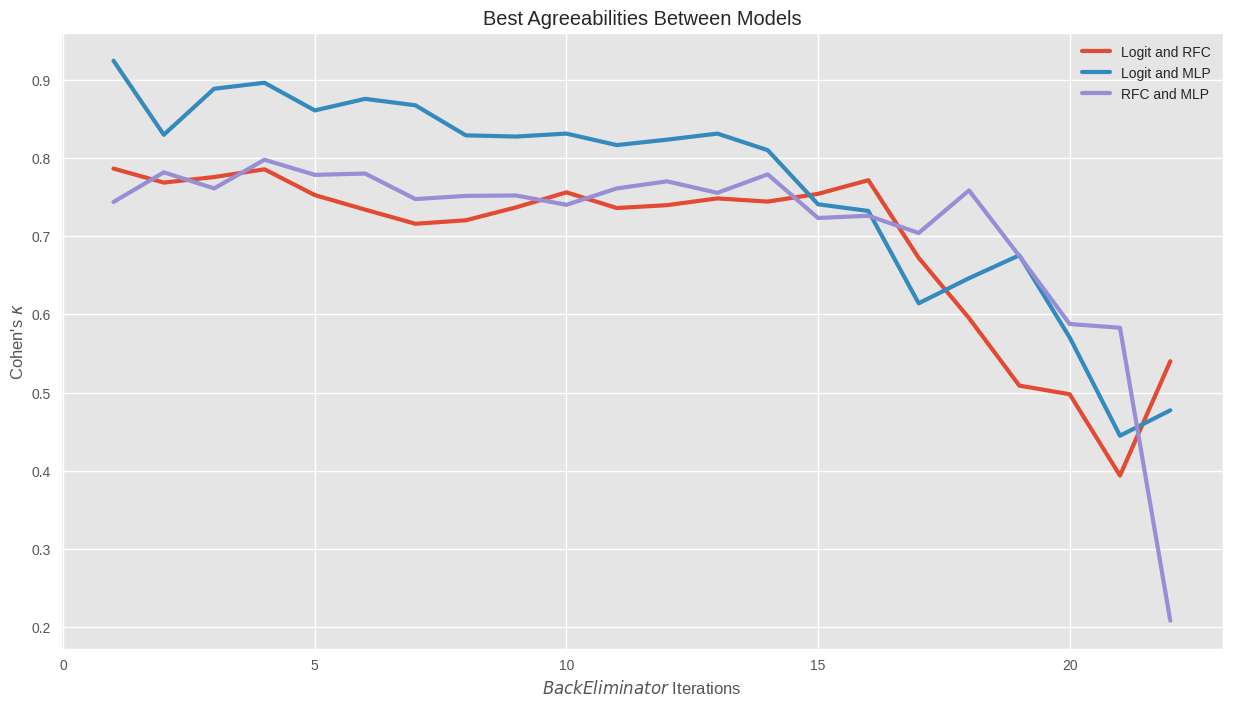

In [159]:
agree_col = 'Best: Agreeability (cohen_kappa)'

algorithm_iterations = logit_rfc.index + 1

plt.style.use('ggplot')
plt.figure(figsize=(15, 8))
plt.plot(algorithm_iterations, logit_rfc[agree_col], label='Logit and RFC', linewidth=3)
plt.plot(algorithm_iterations, logit_mlp[agree_col], label='Logit and MLP', linewidth=3)
plt.plot(algorithm_iterations, rfc_mlp[agree_col], label='RFC and MLP', linewidth=3)
plt.title('Best Agreeabilities Between Models')
plt.ylabel('Cohen\'s $\kappa$')
plt.xlabel('$BackEliminator$ Iterations')
plt.legend()
plt.show()

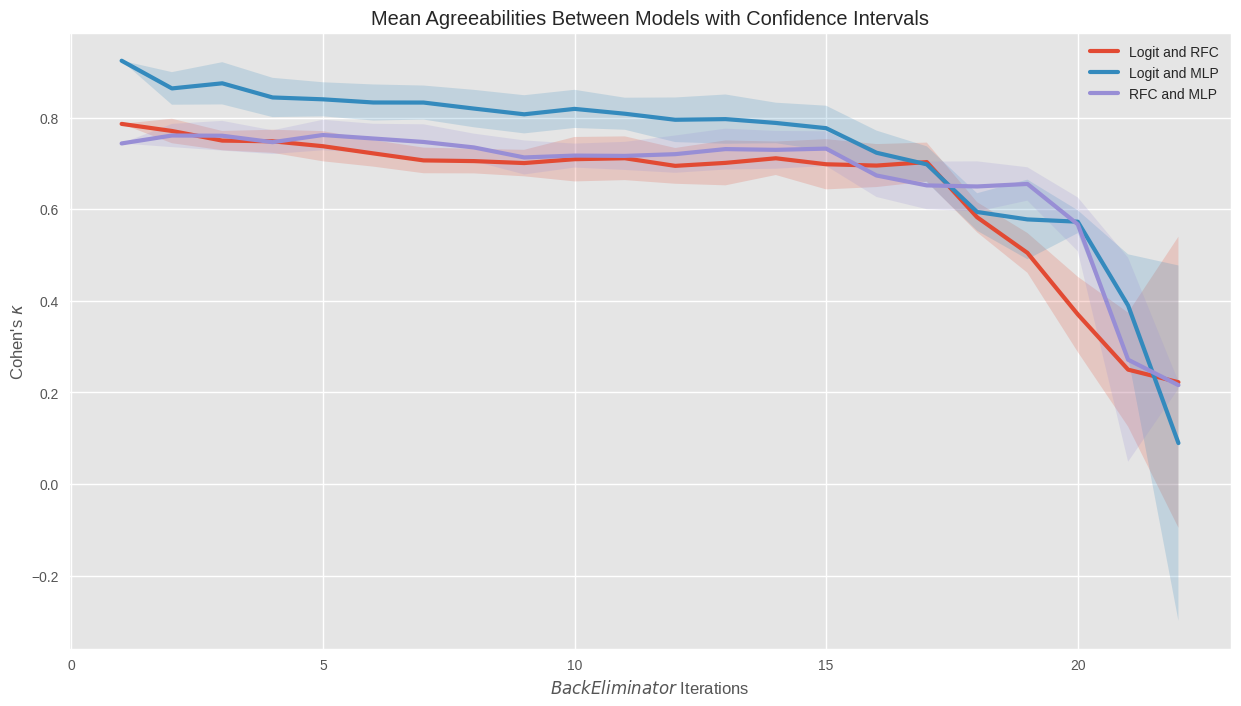

In [163]:
mean_agree_col = 'All: Mean Agreeability (cohen_kappa)'
std_agree_col = 'All: Agreeability St. Dev.'

algorithm_iterations = logit_rfc.index + 1

plt.style.use('ggplot')
plt.figure(figsize=(15, 8))
plt.plot(algorithm_iterations, logit_rfc[mean_agree_col], label='Logit and RFC', linewidth=3)
plt.plot(algorithm_iterations, logit_mlp[mean_agree_col], label='Logit and MLP', linewidth=3)
plt.plot(algorithm_iterations, rfc_mlp[mean_agree_col], label='RFC and MLP', linewidth=3)

plt.fill_between(algorithm_iterations, logit_rfc[mean_agree_col] - logit_rfc[std_agree_col], logit_rfc[mean_agree_col] + logit_rfc[std_agree_col], alpha=0.2)
plt.fill_between(algorithm_iterations, logit_mlp[mean_agree_col] - logit_mlp[std_agree_col], logit_mlp[mean_agree_col] + logit_mlp[std_agree_col], alpha=0.2)
plt.fill_between(algorithm_iterations, rfc_mlp[mean_agree_col] - rfc_mlp[std_agree_col], rfc_mlp[mean_agree_col] + rfc_mlp[std_agree_col], alpha=0.2)

plt.title('Mean Agreeabilities Between Models with Confidence Intervals')
plt.ylabel('Cohen\'s $\kappa$')
plt.xlabel('$BackEliminator$ Iterations')
plt.legend()
plt.show()


### Working Code for 3D Plot

```python

# Create a 3D scatter plot
fig = go.Figure(data=[
    go.Scatter3d(
        x=df.index + 1,
        y=df.iloc[:, 4],
        z=df.iloc[:, 1], 
        mode='lines+markers',
        name=f'{df.columns[1]}',
        text=df['Summary_M1'],
        hoverinfo='text'
    ),
    go.Scatter3d(
        x=df.index + 1,
        y=df.iloc[:, 4],
        z=df.iloc[:, 3], 
        mode='lines+markers',
        name=f'{df.columns[3]}',
        text=df['Summary_M2'],
        hoverinfo='text'
    )
])

# Update layout
fig.update_layout(
    title='Agreeability Coefficients and Model Scores Over Algorithm Iterations',
    scene=dict(
        xaxis_title='Iteration',
        yaxis_title='Agreeability',
        zaxis_title='Model Scores'
    ),
    hovermode='closest'
)

# Show the plot
fig.show()

```

### Dependencies

In [52]:
import numpy as np
import pandas as pd
import statsmodels
import sklearn
import scipy
import plotly
import matplotlib
import seaborn as sns
import tensorflow as tf
import openpyxl
import imblearn
import nbformat

In [53]:
print(f'pandas: {pd.__version__}')
print(f'numpy: {np.__version__}')
print(f'statsmodels: {statsmodels.__version__}')
print(f'sklearn: {sklearn.__version__}')
print(f'scipy: {scipy.__version__}')
print(f'plotly: {plotly.__version__}')
print(f'matplotlib: {matplotlib.__version__}')
print(f'seaborn: {sns.__version__}')
print(f'tensorflow: {tf.__version__}')
print(f'openpyxl: {openpyxl.__version__}')
print(f'imblearn: {imblearn.__version__}')
print(f'nbformat: {nbformat.__version__}')

pandas: 1.5.3
numpy: 1.24.4
statsmodels: 0.13.5
sklearn: 1.1.3
scipy: 1.11.3
plotly: 5.18.0
matplotlib: 3.6.0
seaborn: 0.12.2
tensorflow: 2.14.0
openpyxl: 3.1.2
imblearn: 0.11.0
nbformat: 4.2.0
